In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from mars.io.nsenwb import NSENWB
from mars.tone import band_response
from scipy.signal import spectrogram
from scipy.signal import gaussian

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

In [3]:
nwb = NSENWB.from_existing_nwb('R32_B8', '/Volumes/pss/data/ecog/R32_B8.nwb')

In [6]:
raw_stim_dset = nwb.read_mark(name='raw_stimulus')

In [4]:
lower_t = 10
upper_t = 70
dt = upper_t - lower_t

In [7]:
raw_stim = nwb.index_dset(raw_stim_dset, time_range=[lower_t, upper_t]).flatten()

In [9]:
bnd_resp = band_response(nwb,
                         proc_name='Wvlt_4to1200_54band_CAR1',
                         device_name='ECoG',
                         device_channels=1 + np.arange(128),
                         time_range=[lower_t, upper_t],
                         frq_range=[70,170]).T

In [10]:
fs_sound = 96000 # sound sampling frequency
fs_ecog = 400 # ecog sampling frequency
strf_frame_width = 0.125 # length of STRF window, in seconds
n_timepoints_strf_frame = int(fs_ecog * strf_frame_width) # timepoints in STRF window

# for calculating stft
window_width = 0.0025
nperseg = int(window_width * fs_sound * 2)
noverlap_frac = 0.9
noverlap = int(noverlap_frac * nperseg)
dt_spectrogram = (1 - noverlap_frac) * 0.5 / 100
downsample_idx = int(window_width / dt_spectrogram)

In [12]:
freq, times, Sxx = spectrogram(
    raw_stim, 
    fs=fs_sound, 
    noverlap=noverlap,
    nperseg=nperseg)

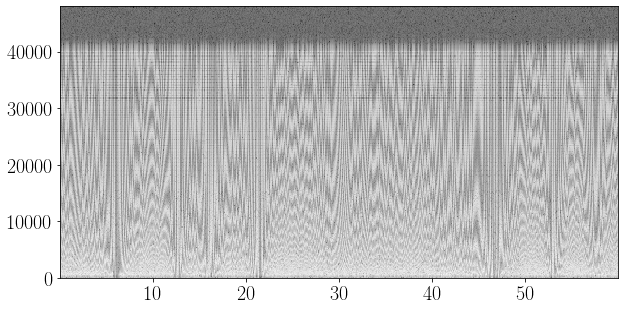

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(times, freq, np.log(Sxx))

In [83]:
# downsample
Sxx_ds = Sxx[:200, ::downsample_idx]
times_ds = times[::downsample_idx]

In [103]:
electrode = 25
responses = bnd_resp[electrode, 1:]

In [104]:
coef = np.zeros((n_timepoints_strf_frame, Sxx_ds.shape[0]))

In [105]:
for timepoint in range(n_timepoints_strf_frame):
    rolled = np.roll(Sxx_ds, shift=timepoint, axis=1)
    X = rolled[:, 49:].T
    y = responses[49:]
    
    ridge = RidgeCV()
    ridge.fit(X, y)
    coef[timepoint] = ridge.coef_

(20000, 40000)

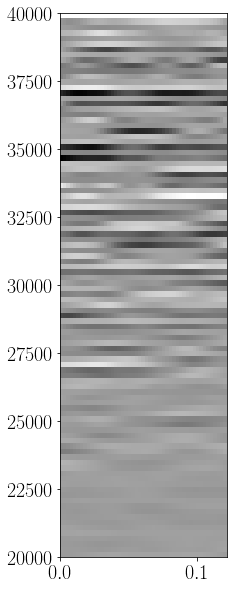

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(3, 10))
ax.pcolormesh(np.arange(0, strf_frame_width, 1 / fs_ecog), freq[:200], coef.T)
ax.set_ylim([20000, 40000])

## full STRF

In [117]:
n_samples = times_ds.size - n_timepoints_strf_frame
n_features = Sxx_ds.shape[0] * n_timepoints_strf_frame

In [118]:
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples)

In [119]:
for sample in range(n_samples):
    base = sample
    end = base + n_timepoints_strf_frame
    X[sample] = Sxx_ds[:, base:end].ravel()
    y[sample] = responses[n_timepoints_strf_frame + sample]

In [120]:
ols = LinearRegression()
ols.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(30000, 40000)

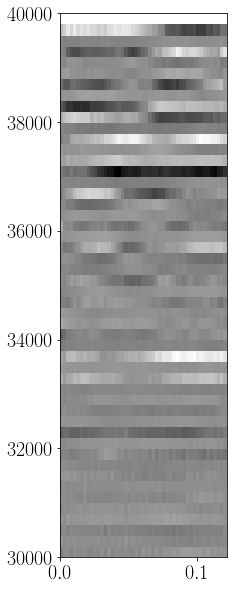

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(3, 10))
ax.pcolormesh(np.arange(0, strf_frame_width, 1 / fs_ecog),
              freq[:200],
              ols.coef_.reshape((200, n_timepoints_strf_frame)))
ax.set_ylim([30000, 40000])

In [130]:
ols.score(X, y)

0.4126813494962982